In [1]:
import torchvision.transforms as transforms
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
from PIL import Image
from glob import glob
import numpy as np
from tqdm import tqdm

In [4]:
orig_img_size = 256
img_size = 64
img_transform = transforms.Compose([transforms.CenterCrop(orig_img_size), # center crop 256x256
                                    transforms.Scale(img_size),  # scale image down to 64x64
                                    transforms.ToTensor(),  # scale from 0-255 to 0-1, convert to tensor
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # normalize (mean, std = 0.5)
                                   ])
def inv_transform(img_array):
    return ((img_array*0.5+0.5)*255).astype(np.uint8)

In [5]:
# NOTE: this loads the entire dataset, and might take awhile (1,315,802 images)
#import torchvision.datasets as dset
#%time dataset = dset.LSUN(db_path=lsun_path, classes=['living_room_train'], transform=img_transform)

### Use following cells to load a subset into a dataset

In [6]:
class LSUNDataset(Dataset):
    """LSUN dataset"""
    def __init__(self, img_file_paths):
        self.imgs = [img_transform(Image.open(img_file_path)) for img_file_path in tqdm(img_file_paths)]

    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, index):
        return self.imgs[index]

In [7]:
%time img_files = glob('/efs/data/LSUN/living_room_train/0/[0-7]/*/*/*/*/*.webp') # assuming LSUN tools used to extract lmdb

CPU times: user 2.36 s, sys: 5.08 s, total: 7.44 s
Wall time: 5min 22s


In [8]:
n_files = 40000
dataset = LSUNDataset(img_files[:n_files]) # don't read in the entire data set for now, for time sake

100%|██████████| 40000/40000 [09:12<00:00, 72.35it/s]


In [9]:
batch_size = 64
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

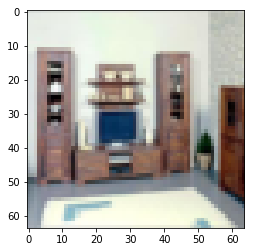

In [10]:
plt.imshow(inv_transform(dataset[0].numpy().transpose(1,2,0)))

### Set up GAN

In [16]:
def initialize_weights(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1 or classname.find('Linear') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [17]:
# variables
ngpu = 1  # adjust value to number of GPUs
dtype = torch.cuda.FloatTensor
if not torch.cuda.is_available():
    ngpu = 0
    dtype = torch.FloatTensor
nc = 3  # RGB image
nz = 100  # size of latent z vector
ngf = img_size  # number of input channels for the last layer of the generator
ndf = img_size  # number of output channels for the first layer of the discriminator

In [95]:
class GeneratorNet(nn.Module):
    def __init__(self):
        super(GeneratorNet, self).__init__()
        self.main = nn.Sequential(nn.Conv2d(nz, ngf*128, kernel_size=1, stride=1, bias=False),
                         nn.BatchNorm2d(ngf*128),
                         nn.LeakyReLU(0.2, inplace=True),
                         nn.PixelShuffle(4),
                         nn.ReflectionPad2d(1),
                         nn.Conv2d(ngf*8, ngf*16, kernel_size=3, stride=1, bias=False),
                         nn.BatchNorm2d(ngf*16),
                         nn.LeakyReLU(0.2, inplace=True),
                         nn.PixelShuffle(2),
                         nn.ReflectionPad2d(2),
                         nn.Conv2d(ngf*4, ngf*8, kernel_size=5, stride=1, bias=False),
                         nn.BatchNorm2d(ngf*8),
                         nn.LeakyReLU(0.2, inplace=True),
                         nn.PixelShuffle(2),
                         nn.ReflectionPad2d(2),
                         nn.Conv2d(ngf*2, ngf*4, kernel_size=5, stride=1, bias=False),
                         nn.BatchNorm2d(ngf*4),
                         nn.LeakyReLU(0.2, inplace=True),
                         nn.PixelShuffle(2),
                         nn.ReflectionPad2d(2),
                         nn.Conv2d(ngf, ngf*4, kernel_size=5, stride=1, bias=False),
                         nn.BatchNorm2d(ngf*4),
                         nn.LeakyReLU(0.2, inplace=True),
                         nn.PixelShuffle(2),
                         nn.ReflectionPad2d(2),
                         nn.Conv2d(ngf, nc, kernel_size=5, stride=1, bias=False),
                         nn.Tanh()
        )

    def forward(self, input):
        if ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(ngpu))
        else:
            output = self.main(input)
        return output

In [96]:
class DiscriminatorNet(nn.Module):
    def __init__(self):
        super(DiscriminatorNet, self).__init__()
        self.main = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(nc, ndf, kernel_size=4, stride=2, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(ndf, ndf*2, kernel_size=4, stride=2, bias=False),
            nn.BatchNorm2d(ndf*2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(ndf*2, ndf*4, kernel_size=4, stride=2, bias=False),
            nn.BatchNorm2d(ndf*4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(ndf*4, ndf*8, kernel_size=4, stride=2, bias=False),
            nn.BatchNorm2d(ndf*8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf*8, 1, kernel_size=4, stride=1, bias=False),  # output: 1 channel - real/fake
            nn.Sigmoid()
        )
        
    def forward(self, input):
        if ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(ngpu))
        else:
            output = self.main(input)
        return output.view(-1, 1).squeeze(1)

In [97]:
genNet = GeneratorNet()
genNet.apply(initialize_weights)
print(genNet)

GeneratorNet (
  (main): Sequential (
    (0): Conv2d(100, 8192, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(8192, eps=1e-05, momentum=0.1, affine=True)
    (2): LeakyReLU (0.2, inplace)
    (3): PixelShuffle (upscale_factor=4)
    (4): ReflectionPad2d (1, 1, 1, 1)
    (5): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (6): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True)
    (7): LeakyReLU (0.2, inplace)
    (8): PixelShuffle (upscale_factor=2)
    (9): ReflectionPad2d (2, 2, 2, 2)
    (10): Conv2d(256, 512, kernel_size=(5, 5), stride=(1, 1), bias=False)
    (11): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
    (12): LeakyReLU (0.2, inplace)
    (13): PixelShuffle (upscale_factor=2)
    (14): ReflectionPad2d (2, 2, 2, 2)
    (15): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1), bias=False)
    (16): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
    (17): LeakyReLU (0.2, inplace)
    (18): PixelShuffle (upsca

In [98]:
discNet = DiscriminatorNet()
discNet.apply(initialize_weights)
print(discNet)

DiscriminatorNet (
  (main): Sequential (
    (0): ReflectionPad2d (1, 1, 1, 1)
    (1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), bias=False)
    (2): LeakyReLU (0.2, inplace)
    (3): ReflectionPad2d (1, 1, 1, 1)
    (4): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), bias=False)
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (6): LeakyReLU (0.2, inplace)
    (7): ReflectionPad2d (1, 1, 1, 1)
    (8): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), bias=False)
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
    (10): LeakyReLU (0.2, inplace)
    (11): ReflectionPad2d (1, 1, 1, 1)
    (12): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), bias=False)
    (13): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
    (14): LeakyReLU (0.2, inplace)
    (15): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (16): Sigmoid ()
  )
)


In [99]:
# loss functions
criterion = nn.BCELoss()
if torch.cuda.is_available():
    criterion.cuda()

def discriminator_loss(output_real, output_fake):
    """
    Computes the discriminator loss described above.
    
    Inputs:
    - output_real: PyTorch Variable of shape (N,) giving scores for the real data.
    - output_fake: PyTorch Variable of shape (N,) giving scores for the fake data.
    
    Returns:
    - loss: PyTorch Variable containing (scalar) the loss for the discriminator.
    """
    true_labels = Variable(torch.ones(output_real.size()).type(dtype))
    true_loss = criterion(output_real, true_labels)

    fake_labels = Variable(torch.zeros(output_fake.size()).type(dtype))
    fake_loss = criterion(output_fake, fake_labels)
    
    loss = true_loss + fake_loss
    return loss

def generator_loss(output_fake):
    """
    Computes the generator loss described above.

    Inputs:
    - loutput_fake: PyTorch Variable of shape (N,) giving scores for the fake data.
    
    Returns:
    - loss: PyTorch Variable containing the (scalar) loss for the generator.
    """
    fake_labels = Variable(torch.ones(output_fake.size()).type(dtype))
    loss = criterion(output_fake, fake_labels)

    return loss

In [100]:
# optimizers
lr = 0.0002
optD = optim.Adam(discNet.parameters(), lr=lr, betas=(0.5, 0.999))
optG = optim.Adam(genNet.parameters(), lr=lr, betas=(0.5, 0.999))

In [101]:
if torch.cuda.is_available():
    discNet.cuda()
    genNet.cuda()

In [102]:
n_epochs = 25
for epoch in range(n_epochs):
    for i, data in enumerate(dataloader):
        discNet.zero_grad()
        input_real = Variable(data).type(dtype)
        output_real = discNet(input_real)
        D_x = output_real.data.mean()
        
        noise = Variable(torch.FloatTensor(batch_size, nz, 1, 1).normal_(0, 1)).type(dtype)
        input_fake = genNet(noise).detach()
        output_fake = discNet(input_fake)
        D_G_z1 = output_fake.data.mean()
        
        disc_loss = discriminator_loss(output_real, output_fake)
        disc_loss.backward()
        optD.step()

        genNet.zero_grad()
        noise = Variable(torch.FloatTensor(batch_size, nz, 1, 1).normal_(0, 1)).type(dtype)
        input_fake = genNet(noise)
        gen_output_fake = discNet(input_fake)
        D_G_z2 = gen_output_fake.data.mean()
        gen_loss = generator_loss(gen_output_fake)
        gen_loss.backward()
        optG.step()
        
        if i % 100 == 0:
            print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
              % (epoch, n_epochs, i, len(dataloader),
                 disc_loss.data[0], gen_loss.data[0], D_x, D_G_z1, D_G_z2))

[0/25][0/625] Loss_D: 1.7045 Loss_G: 1.0396 D(x): 0.4461 D(G(z)): 0.4243 / 0.4274
[0/25][100/625] Loss_D: 1.2185 Loss_G: 2.3675 D(x): 0.7319 D(G(z)): 0.4745 / 0.1656
[0/25][200/625] Loss_D: 0.8691 Loss_G: 1.3964 D(x): 0.6291 D(G(z)): 0.2624 / 0.3008
[0/25][300/625] Loss_D: 1.1292 Loss_G: 1.3483 D(x): 0.6019 D(G(z)): 0.3908 / 0.3017
[0/25][400/625] Loss_D: 1.2866 Loss_G: 1.0144 D(x): 0.4442 D(G(z)): 0.2686 / 0.4072
[0/25][500/625] Loss_D: 1.1407 Loss_G: 1.2492 D(x): 0.5467 D(G(z)): 0.3539 / 0.3198
[0/25][600/625] Loss_D: 1.4372 Loss_G: 0.6743 D(x): 0.3219 D(G(z)): 0.1396 / 0.5538
[1/25][0/625] Loss_D: 1.2384 Loss_G: 0.7739 D(x): 0.4068 D(G(z)): 0.1848 / 0.4957
[1/25][100/625] Loss_D: 1.1568 Loss_G: 1.9202 D(x): 0.8352 D(G(z)): 0.5676 / 0.2036
[1/25][200/625] Loss_D: 1.2314 Loss_G: 0.6338 D(x): 0.4866 D(G(z)): 0.2889 / 0.5623
[1/25][300/625] Loss_D: 1.3058 Loss_G: 1.1901 D(x): 0.4530 D(G(z)): 0.2911 / 0.3688
[1/25][400/625] Loss_D: 1.0329 Loss_G: 1.4445 D(x): 0.6835 D(G(z)): 0.4184 / 0.2

[14/25][0/625] Loss_D: 0.6652 Loss_G: 4.0418 D(x): 0.9472 D(G(z)): 0.3812 / 0.0368
[14/25][100/625] Loss_D: 0.4728 Loss_G: 2.6013 D(x): 0.7112 D(G(z)): 0.0813 / 0.1341
[14/25][200/625] Loss_D: 0.5279 Loss_G: 4.1137 D(x): 0.9550 D(G(z)): 0.3354 / 0.0368
[14/25][300/625] Loss_D: 0.4835 Loss_G: 2.2626 D(x): 0.8183 D(G(z)): 0.1933 / 0.1704
[14/25][400/625] Loss_D: 1.0657 Loss_G: 1.2951 D(x): 0.4740 D(G(z)): 0.0823 / 0.3724
[14/25][500/625] Loss_D: 0.4293 Loss_G: 2.4940 D(x): 0.9150 D(G(z)): 0.2467 / 0.1320
[14/25][600/625] Loss_D: 0.6719 Loss_G: 4.0368 D(x): 0.9388 D(G(z)): 0.3937 / 0.0441
[15/25][0/625] Loss_D: 0.3838 Loss_G: 2.8328 D(x): 0.8190 D(G(z)): 0.1423 / 0.1088
[15/25][100/625] Loss_D: 0.8005 Loss_G: 1.9011 D(x): 0.5435 D(G(z)): 0.0726 / 0.2642
[15/25][200/625] Loss_D: 0.3736 Loss_G: 3.0690 D(x): 0.8599 D(G(z)): 0.1621 / 0.0956
[15/25][300/625] Loss_D: 0.3895 Loss_G: 2.8439 D(x): 0.7799 D(G(z)): 0.0895 / 0.1047
[15/25][400/625] Loss_D: 0.5757 Loss_G: 5.1224 D(x): 0.9170 D(G(z)): 

Process Process-46:
Process Process-45:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 34, in _worker_loop
    r = index_queue.get()
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 34, in _worker_loop
    r = index_queue.get()
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 342, in get
    with self._rlock:
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 343, in get
    res = self._reader.recv_bytes()


KeyboardInterrupt: 

In [103]:
import torchvision.datasets as dset
%time test_dataset = dset.LSUN(db_path='/efs/data/LSUN', classes=['living_room_val'], transform=img_transform)
test_dataloader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=1)

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 30.3 ms


In [104]:
test_input = next(iter(test_dataloader))

In [105]:
test_var = Variable(test_input).type(dtype)

In [106]:
test_output = discNet(test_var)

In [107]:
test_output.cpu().data.numpy()

array([ 0.88863307], dtype=float32)

Fake image score: [ 0.03786236]
Fake image score: [ 0.00451964]
Fake image score: [ 0.11349761]
Fake image score: [ 0.16096017]
Fake image score: [ 0.17895946]
Fake image score: [ 0.38555717]
Fake image score: [ 0.01348511]
Fake image score: [ 0.15971942]
Fake image score: [ 0.10890337]


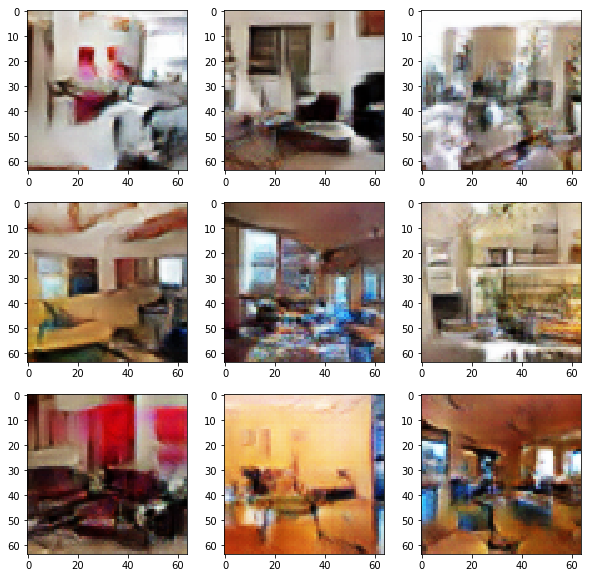

In [108]:
# - test against fake images
genNet.eval()
plt.figure(figsize=(10,10))
for i in range(1,10):
    test_noise = torch.FloatTensor(1, nz, 1, 1).normal_(0,1)
    test_noisev = Variable(test_noise)
    if torch.cuda.is_available():
        test_noisev = test_noisev.cuda()
    test_fake_input = genNet(test_noisev)
    test_fake_output = discNet(test_fake_input)
    print('Fake image score: ' + str(test_fake_output.cpu().data.numpy()))
    plt.subplot(3, 3, i)
    plt.imshow(inv_transform(test_fake_input.cpu().data.numpy()[0].transpose(1,2,0)))